# Immorthon

## Installation des dépendances

In [85]:
!pip install transformers
!pip install datasets

## Import des modules et classes

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers.models.auto.tokenization_auto import AutoTokenizer
from transformers.models.auto.modeling_auto import AutoModelForCausalLM
from transformers.tokenization_utils_base import BatchEncoding
from transformers.training_args import TrainingArguments
from transformers.trainer import Trainer

## Préparation de l'environnement

In [88]:
# cloner si on est sur colab
if 'google.colab' in str(get_ipython()):
    repoDir = "immorthon/"
    !rm -rf immorthon
    !git clone https://github.com/sully-vian/immorthon.git
    !cd immorthon && unzip model.zip
else:
    repoDir = ""

dicoDir = "dictionnaries/"

# par ordre croissant de taille
dicoNames = ["dico-ef.csv", "dico-mit.csv", "dico-alpha.csv"]
dicoPath = dicoDir + dicoNames[2]

dicoPath = repoDir + dicoPath

# set pandas to print full strings
pd.set_option('display.max_colwidth', None)

Cloning into 'immorthon'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 104 (delta 41), reused 64 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 6.74 MiB | 8.63 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Archive:  model.zip
   creating: model/
  inflating: model/model.safetensors  
  inflating: model/generation_config.json  
  inflating: model/config.json       


## Chargement et préparation les données

In [89]:
# renvoie le dataFrame avec la colonne "text" ajoutée
def loadAndPreprocessData(dicoPath:str) -> pd.DataFrame:
    df = pd.read_csv(dicoPath, encoding="utf-8", on_bad_lines="error", na_filter=False)
    # On ne veut pas de valeur "None"
    if df.isnull().values.any():
        raise ValueError("None values in dataframe")
    # créer la colonne sur laquelle on va entrainer le modèle
    df["text"] = "Define: " + df["word"] + "\n" + df["definition"]
    return df

df = loadAndPreprocessData(dicoPath)

# séparer aléatoirement la data en train et test
dataset = Dataset.from_pandas(df[["text"]])
splitDataset = dataset.train_test_split(test_size=0.1)

## Représentation des données

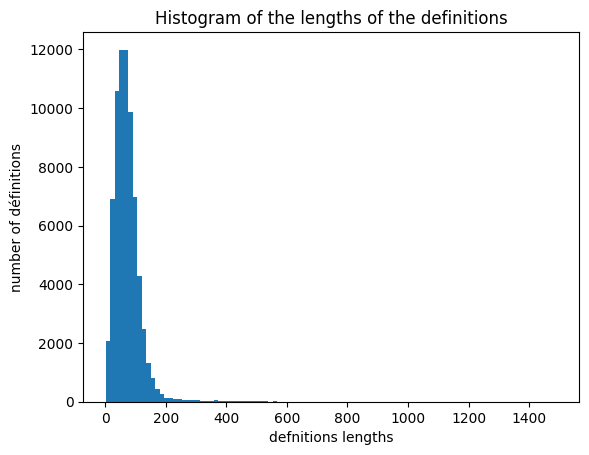

In [90]:
definition_lengths = [len(definition) for definition in df["definition"]]
plt.hist(definition_lengths, bins=100)
plt.title('Histogram of the lengths of the definitions')
plt.xlabel('defnitions lengths')
plt.ylabel('number of définitions')
plt.show()

## Import du modèle et du tokeniseur

In [91]:
# par ordre croissant de taille
modelNames = [
    repoDir + "model", # modèle entrainé sur des définitions
    "distilgpt2",
    "gpt2",
    "databricks/dolly-v2-3b" # trop lourd pour un T4 GPU
]
modelName = modelNames[1]

model = AutoModelForCausalLM.from_pretrained(modelName)
tokenizer = AutoTokenizer.from_pretrained(modelName)
tokenizer.pad_token = tokenizer.eos_token


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/config.json
Model config GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
   

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/model.safetensors
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}



tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/config.json
Model config GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
   

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/config.json
Model config GPT2Config {
  "_num_labels": 1,
  "activat

## Tokenisation des données d'entrainement

In [92]:
def tokenizeDataSet(dataset: DatasetDict, tokenizer: AutoTokenizer, max_length) -> DatasetDict:
    def tokenize(examples: pd.DataFrame) -> BatchEncoding:
        encoding = tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length
        )
        encoding["labels"] = encoding["input_ids"].copy()
        return encoding
    return dataset.map(tokenize, batched=True)

tokenizedDataset = tokenizeDataSet(splitDataset, tokenizer, 100)

Map:   0%|          | 0/63909 [00:00<?, ? examples/s]

Map:   0%|          | 0/7101 [00:00<?, ? examples/s]

## Entrainement

In [94]:
trainingArgs = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="no",
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=trainingArgs,
    train_dataset=tokenizedDataset["train"],
    eval_dataset=tokenizedDataset["test"],
    processing_class=tokenizer,
)

trainer.train()

PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 63,909
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7,989
  Number of trainable parameters = 81,912,576


Step,Training Loss
10,0.602100
20,0.619400
30,0.506600
40,0.550900
50,0.551000
60,0.560800
70,0.496900
80,0.531200
90,0.527300
100,0.574400


Saving model checkpoint to ./results/checkpoint-7989
Configuration saved in ./results/checkpoint-7989/config.json
Configuration saved in ./results/checkpoint-7989/generation_config.json
Model weights saved in ./results/checkpoint-7989/model.safetensors
tokenizer config file saved in ./results/checkpoint-7989/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-7989/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=7989, training_loss=0.5485066305130202, metrics={'train_runtime': 1312.5608, 'train_samples_per_second': 48.69, 'train_steps_per_second': 6.087, 'total_flos': 1630782620467200.0, 'train_loss': 0.5485066305130202, 'epoch': 1.0})

## Affichage des données d'entrainement

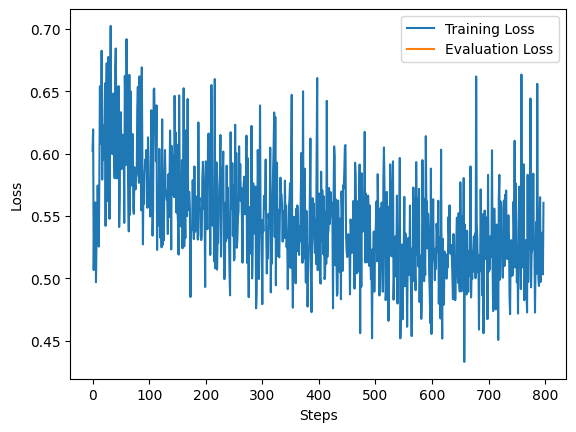

In [109]:
logHistory = trainer.state.log_history

trainLosses = [log["loss"] for log in logHistory if "loss" in log]
evalLosses = [log["eval_loss"] for log in logHistory if "eval_loss" in log] # vide, mais jsp pk

plt.plot(trainLosses, label="Training Loss")
plt.plot(evalLosses, label="Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Utilisation du modèle

In [106]:
from transformers.pipelines import pipeline

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

def generate(prompt, numDef):
    fullPrompt = f"Define: {prompt}\n"
    results = generator(fullPrompt, max_length=64, num_return_sequences=numDef, do_sample=True, temperature=0.7, truncation=True)
    return [result["generated_text"] for result in results]

for result in generate("maxitruck", 3):
    print(result, end="\n\n")

Device set to use cuda:0


Define: maxitruck
a large vehicle with a roof and a roof, used for carrying heavy loads

Define: maxitruck
a truck with a wheel that you can ride as a machine

Define: maxitruck
a car that has one or more wheels and that has two or more wheels and that has one or more wheels and that is going to do a lot of work



## Enregistrement du modèle entrainé

In [107]:
# enregistrer le modèle
model.save_pretrained("model")
tokenizer.save_pretrained("model")
# zipper le modèle
!zip -r model.zip model

Configuration saved in model/config.json
Configuration saved in model/generation_config.json
Model weights saved in model/model.safetensors
tokenizer config file saved in model/tokenizer_config.json
Special tokens file saved in model/special_tokens_map.json


updating: model/ (stored 0%)
updating: model/model.safetensors (deflated 7%)
updating: model/generation_config.json (deflated 24%)
updating: model/vocab.json (deflated 59%)
updating: model/tokenizer_config.json (deflated 54%)
updating: model/config.json (deflated 51%)
updating: model/merges.txt (deflated 53%)
updating: model/tokenizer.json (deflated 82%)
updating: model/special_tokens_map.json (deflated 60%)
